<a href="https://colab.research.google.com/github/borundev/fastai_examples/blob/main/fastbook_chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqqq fastai

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 


In [2]:
from fastai.vision.all import *

In [3]:
key='XXX'

In [4]:
def search_images_bing(key, term, min_sz=128, max_images=150):
    params = dict(q=term, count=max_images, min_height=min_sz, min_width=min_sz)
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers={"Ocp-Apim-Subscription-Key":key}, params=params)
    response.raise_for_status()
    return L(response.json()['value'])

In [5]:
search_images_bing(key,'bear')

(#150) [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=bear&id=253530A4C98301E764188694E15736A5AFA07C8A&simid=608032967283705989', 'name': "Man Mauled by Brown Bear on Hiking Trip Survived After Girlfriend Screamed 'Punch it in the Face ...", 'thumbnailUrl': 'https://tse4.mm.bing.net/th?id=OIP.Tt2U8mH2zCQlE8eSwdV8WQHaE5&pid=Api', 'datePublished': '2019-06-12T00:04:00.0000000Z', 'isFamilyFriendly': True, 'contentUrl': 'https://d.newsweek.com/en/full/1502347/brown-bear.jpg', 'hostPageUrl': 'https://www.newsweek.com/romania-brown-bear-attack-mauling-andi-bauer-lara-booth-hiking-national-park-service-1443070', 'contentSize': '4485800 B', 'encodingFormat': 'jpeg', 'hostPageDisplayUrl': 'https://www.newsweek.com/romania-brown-bear-attack-mauling-andi-bauer-lara-booth-hiking...', 'width': 2500, 'height': 1651, 'hostPageFavIconUrl': 'https://www.bing.com/th?id=ODF.uTJA7JDoTGKvff5o3jotfg&pid=Api', 'hostPageDomainFriendlyName': 'Newsweek', 'hostPageDiscoveredDat

In [13]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)


150

In [15]:
!mkdir images

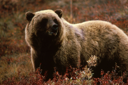

In [16]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [19]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists(): path.mkdir()
for o in bear_types: 
  dest = (path/o)
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'{o} bear')
  download_images(dest, urls=results.attrgot('contentUrl'))

In [26]:
fns = get_image_files(path)
fns

(#408) [Path('bears/teddy/00000092.jpg'),Path('bears/teddy/00000108.jpg'),Path('bears/teddy/00000010.jpg'),Path('bears/teddy/00000009.jpg'),Path('bears/teddy/00000144.png'),Path('bears/teddy/00000147.jpg'),Path('bears/teddy/00000074.jpg'),Path('bears/teddy/00000022.jpg'),Path('bears/teddy/00000002.png'),Path('bears/teddy/00000054.jpg')...]

In [27]:
failed = verify_images(fns)
failed

(#0) []

In [28]:
failed.map(Path.unlink);

In [29]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): 
    self.loaders = loaders 
  def __getitem__(self, i): 
    return self.loaders[i] 
  train,valid = add_props(lambda i,self: self[i])

In [30]:
bears = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128))

In [31]:
dls = bears.dataloaders(path)

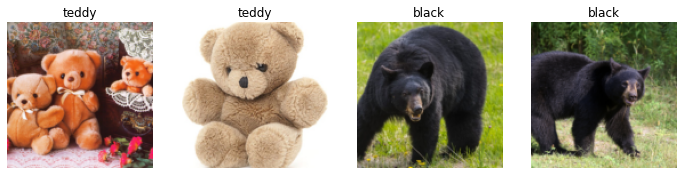

In [32]:
dls.valid.show_batch(max_n=4, nrows=1)


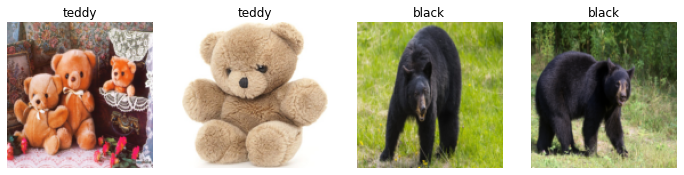

In [33]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

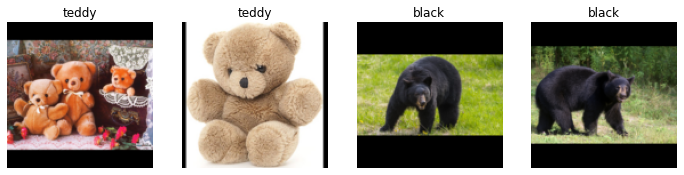

In [34]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


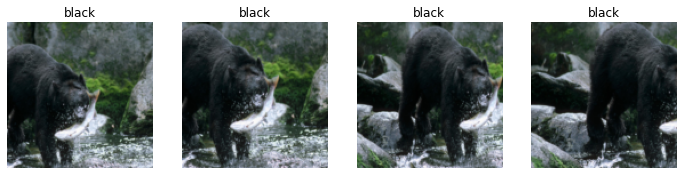

In [38]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


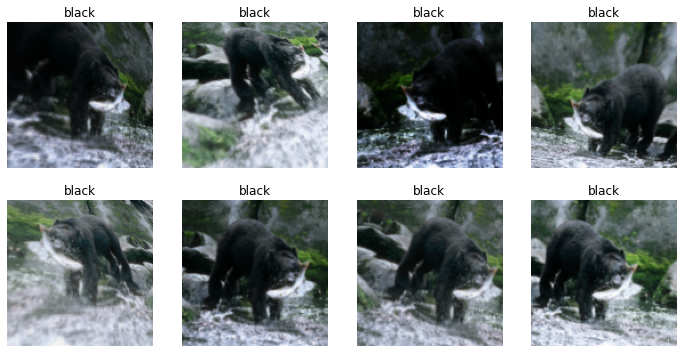

In [39]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [40]:
bears = bears.new(
        item_tfms=RandomResizedCrop(224, min_scale=0.5),
        batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [41]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.398874,0.179321,0.049383,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.178512,0.052721,0.012346,00:15
1,0.113583,0.035280,0.012346,00:15
2,0.078285,0.021312,0.012346,00:15
3,0.059703,0.017847,0.012346,00:15


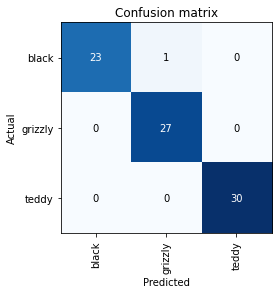

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


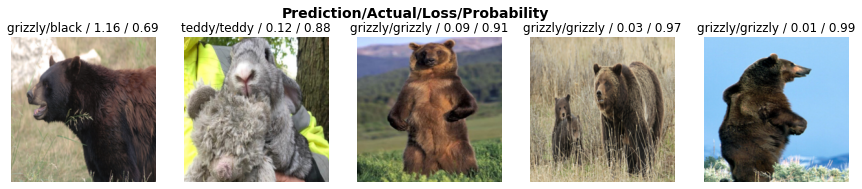

In [45]:
interp.plot_top_losses(5, nrows=1)